# Proof-of-Concept for one experiment

In [507]:
params = dict(
    experiment_dir=Path("/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/"),
    imaging_scheme="TL/470/410/470/410",
    register=True
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()

03:34:54 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
03:34:54 INFO:Segmenting pharynxes
03:34:56 INFO:Centering and rotating pharynxes


03:35:05 INFO:Calculating midlines


03:35:07 INFO:Measuring under midlines


03:35:08 INFO:Registering profiles


03:37:11 INFO:Trimming intensity data
03:37:12 INFO:Calculating redox measurements
03:37:12 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
03:37:12 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
03:37:13 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
03:37:13 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47


In [508]:
warp_data_0 = np.squeeze(ex_unreg.warps[0].data_matrix)
iden_0 = np.linspace(0,1,warp_data.shape[-1])
d_iden_0 = np.abs((iden - warp_data))

warp_data_1 = np.squeeze(ex_unreg.warps[1].data_matrix)
iden_1 = np.linspace(0,1,warp_data.shape[-1])
d_iden_1 = np.abs((iden - warp_data))

In [509]:
mvmt = ex_unreg.movement
mvmt = pd.DataFrame(mvmt.to_records())
mvmt[mvmt.pair == 0]

,animal,pair,anterior,posterior,sides_of_tip,tip
0,0,0,0,0,0,1
2,1,0,0,0,1,0
4,2,0,0,0,0,0
6,3,0,0,0,0,0
8,4,0,0,0,0,0
...,...,...,...,...,...,...
236,118,0,0,0,0,0
238,119,0,3,3,3,3
240,120,0,0,0,0,0
242,121,0,0,0,0,0


In [510]:
w1_tbl

,value,region,animal
0,0.000229,pm3,0
1,0.000000,pm3,1
2,0.000000,pm3,2
3,0.001086,pm3,3
4,0.000000,pm3,4
...,...,...,...
118,0.000000,pm7,118
119,0.011625,pm7,119
120,0.000000,pm7,120
121,0.000000,pm7,121


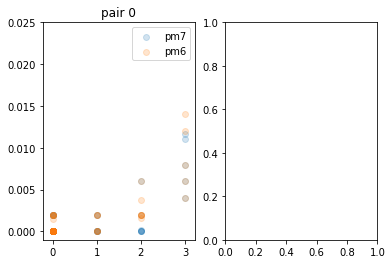

In [514]:
reload(profile_processing);

alpha = 0.2

fig, axes = plt.subplots(1,2)

ax = axes[0]
w0_tbl = profile_processing.summarize_over_regions(d_iden_0, ex_unreg.regions, rescale_boundaries=True)
ax.scatter(mvmt[(mvmt.pair == 0)].posterior, w0_tbl[(w0_tbl.region == 'pm7')].value, alpha=alpha, label='pm7')
ax.scatter(mvmt[(mvmt.pair == 0)].posterior, w0_tbl[(w0_tbl.region == 'pm6')].value, alpha=alpha, label='pm6')
ax.legend();
ax.set_title('pair 0');
ax.set_ylim(-0.001, 0.025);

# ax = axes[1]
# w1_tbl = profile_processing.summarize_over_regions(d_iden_1, ex_unreg.regions, rescale=True)
# ax.scatter(mvmt[(mvmt.pair == 1)].posterior, w1_tbl[(w1_tbl.region == 'pm7')].value, alpha=alpha, label='pm7')
# ax.scatter(mvmt[(mvmt.pair == 1)].posterior, w1_tbl[(w1_tbl.region == 'pm6')].value, alpha=alpha, label='pm6')
# ax.set_ylim(-0.001, 0.025)
# ax.set_title('pair 1');
# plt.tight_layout()


In [518]:
err = da.get_resid_rr(ex_unreg.trimmed_profiles)
err

<xarray.DataArray (strain: 123, position: 300)>
array([[0.04084 , 0.039419, 0.037868, ..., 0.017252, 0.018456, 0.018456],
       [0.026776, 0.024309, 0.0218  , ..., 0.03167 , 0.03278 , 0.03278 ],
       [0.125722, 0.114848, 0.105627, ..., 0.02343 , 0.023023, 0.023023],
       ...,
       [0.006861, 0.009808, 0.01216 , ..., 0.013304, 0.013621, 0.013621],
       [0.077577, 0.071463, 0.066342, ..., 0.043892, 0.045545, 0.045545],
       [0.034888, 0.036543, 0.037479, ..., 0.054555, 0.056428, 0.056428]])
Coordinates:
    wavelength  <U1 'r'
  * strain      (strain) object 'HD233' 'HD233' 'HD233' ... 'SAY47' 'SAY47'
Dimensions without coordinates: position

In [521]:
w0_tbl = profile_processing.summarize_over_regions(d_iden_0, ex_unreg.regions, rescale_boundaries=True)
err_tbl = profile_processing.summarize_over_regions(err, ex_unreg.regions, rescale_boundaries=True)
err_tbl.columns = ['err', 'region', 'animal']
w0_tbl.columns = ['warp', 'region', 'animal']

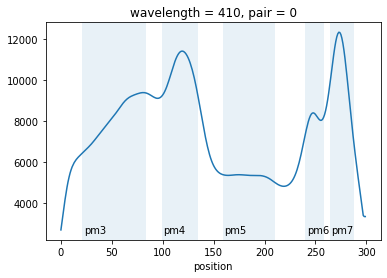

In [531]:
fig, ax = plt.subplots()
ex_unreg.trimmed_profiles.sel(wavelength='410', pair=0).mean(dim='strain').plot(ax=ax)

plots.add_regions_to_axis(ax=ax, regions=ex_unreg.scaled_regions)

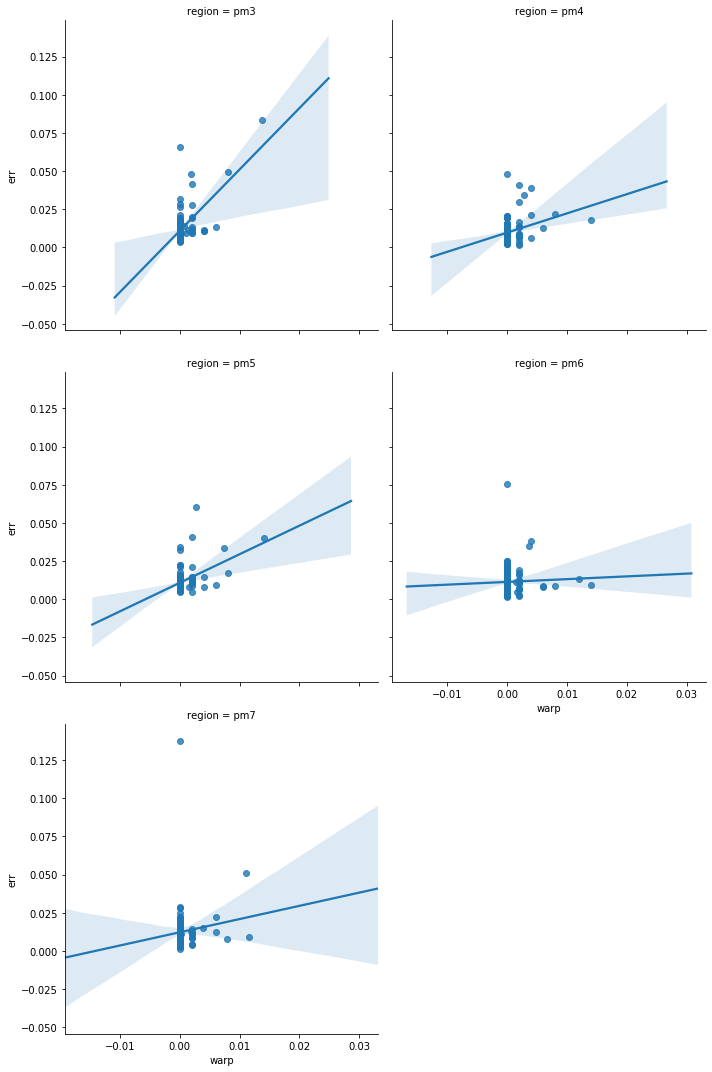

In [536]:
df = w0_tbl.merge(err_tbl)

sns.lmplot(x='warp', y='err', data=df, col='region', col_wrap=2)

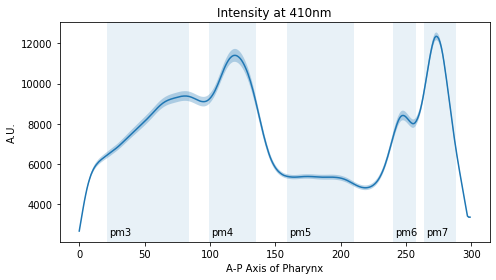

In [36]:
fig, ax = plt.subplots(figsize=(7,4))
plots.plot_profile_avg_with_bounds(ex_unreg.trimmed_profiles.sel(wavelength='410', pair=0), ax=ax)
plots.add_regions_to_axis(ax, ex_unreg.scaled_regions)
ax.set_ylabel('A.U.')
ax.set_xlabel('A-P Axis of Pharynx')
ax.set_title('Intensity at 410nm');
plt.tight_layout();
plt.savefig('/Users/sean/Desktop/ex_i410.png', dpi=300)

# Now let's do it for all experiments

In [538]:
meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio")

df = da.load_all_summaries(meta_dir)
df = df[(df.strategy == 'single_reg') & (df.region == 'pm3')]
df_0 = df[df.pair == 0]
df_1 = df[df.pair == 1]

df = pd.concat([df_0, df_1])

In [542]:
warps = [[], []]
i410s = [[], []]
i470s = [[], []]

for pair in tqdm_notebook([0, 1]):
    for exp_dir in tqdm_notebook(list(sorted(meta_dir.iterdir())), leave=False):
        if not exp_dir.is_dir():
            continue
        ex = experiment.PairExperiment(exp_dir, "TL/470/410/470/410", register=False).full_pipeline()

        i410 = ex.untrimmed_profiles.sel(wavelength='410', pair=pair)
        i470 = ex.untrimmed_profiles.sel(wavelength='470', pair=pair)
        _, _, w = profile_processing.register_pair(i410, i470, warp_lam=10 ** -1, rough_nbasis=64)

        w_data = np.squeeze(w.data_matrix)
        warps[pair].append(w)
        i410s[pair].append(i410)
        i470s[pair].append(i470)

04:05:13 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:05:13 INFO:Segmenting pharynxes
04:05:15 INFO:Centering and rotating pharynxes


04:05:26 INFO:Calculating midlines


04:05:28 INFO:Measuring under midlines


04:05:30 INFO:Trimming intensity data
04:05:30 INFO:Calculating redox measurements
04:05:30 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:05:30 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
04:05:31 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
04:05:31 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:05:41 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:05:41 INFO:Segmenting pharynxes
04:05:42 INFO:Centering and rotating pharynxes


04:05:50 INFO:Calculating midlines


04:05:51 INFO:Measuring under midlines


04:05:52 INFO:Trimming intensity data
04:05:52 INFO:Calculating redox measurements
04:05:52 INFO:Saving 2017_02_23-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:05:52 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-summary_table.csv
04:05:53 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-profile_data.nc
04:05:53 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:06:02 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:06:02 INFO:Segmenting pharynxes
04:06:03 INFO:Centering and rotating pharynxes


04:06:13 INFO:Calculating midlines


04:06:16 INFO:Measuring under midlines


04:06:17 INFO:Trimming intensity data
04:06:18 INFO:Calculating redox measurements
04:06:18 INFO:Saving 2017_02_27-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:06:18 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-summary_table.csv
04:06:19 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-profile_data.nc
04:06:19 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:06:29 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:06:29 INFO:Segmenting pharynxes
04:06:31 INFO:Centering and rotating pharynxes


04:06:39 INFO:Calculating midlines


04:06:40 INFO:Measuring under midlines


04:06:41 INFO:Trimming intensity data
04:06:41 INFO:Calculating redox measurements
04:06:41 INFO:Saving 2017_03_01_HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:06:41 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-summary_table.csv
04:06:42 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-profile_data.nc
04:06:42 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:06:51 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:06:51 INFO:Segmenting pharynxes
04:06:52 INFO:Centering and rotating pharynxes


04:06:58 INFO:Calculating midlines


04:06:59 INFO:Measuring under midlines


04:06:59 INFO:Trimming intensity data
04:07:00 INFO:Calculating redox measurements
04:07:00 INFO:Saving 2017_08_15-HD233_4mM_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:07:00 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-summary_table.csv
04:07:00 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-profile_data.nc
04:07:00 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:07:07 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:07:07 INFO:Segmenting pharynxes
04:07:08 INFO:Centering and rotating pharynxes


04:07:10 INFO:Calculating midlines


04:07:10 INFO:Measuring under midlines


04:07:10 INFO:Trimming intensity data
04:07:10 INFO:Calculating redox measurements
04:07:11 INFO:Saving 2017_08_23-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:07:11 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-summary_table.csv
04:07:11 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-profile_data.nc
04:07:11 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:07:14 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:07:14 INFO:Segmenting pharynxes
04:07:16 INFO:Centering and rotating pharynxes


04:07:22 INFO:Calculating midlines


04:07:23 INFO:Measuring under midlines


04:07:23 INFO:Trimming intensity data
04:07:24 INFO:Calculating redox measurements
04:07:24 INFO:Saving 2017_08_24-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:07:24 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-summary_table.csv
04:07:25 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-profile_data.nc
04:07:25 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:07:32 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:07:32 INFO:Segmenting pharynxes
04:07:33 INFO:Centering and rotating pharynxes


04:07:35 INFO:Calculating midlines


04:07:35 INFO:Measuring under midlines


04:07:36 INFO:Trimming intensity data
04:07:36 INFO:Calculating redox measurements
04:07:36 INFO:Saving 2017_08_25-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:07:36 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-summary_table.csv
04:07:36 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-profile_data.nc
04:07:36 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:07:40 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:07:40 INFO:Segmenting pharynxes
04:07:41 INFO:Centering and rotating pharynxes


04:07:43 INFO:Calculating midlines


04:07:43 INFO:Measuring under midlines


04:07:44 INFO:Trimming intensity data
04:07:44 INFO:Calculating redox measurements
04:07:44 INFO:Saving 2017_08_25-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:07:44 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-summary_table.csv
04:07:44 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-profile_data.nc
04:07:44 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:07:48 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:07:48 INFO:Segmenting pharynxes
04:07:50 INFO:Centering and rotating pharynxes


04:07:59 INFO:Calculating midlines


04:08:00 INFO:Measuring under midlines


04:08:01 INFO:Trimming intensity data
04:08:02 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm-testing/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
04:08:02 INFO:Saving 2019_04_03-ASI_ablation inside /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:08:02 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-17_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-summary_table.csv
04:08:02 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-17_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-profile_data.nc
04:08:02 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation


04:08:12 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:08:12 INFO:Segmenting pharynxes
04:08:14 INFO:Centering and rotating pharynxes


04:08:22 INFO:Calculating midlines


04:08:23 INFO:Measuring under midlines


04:08:25 INFO:Trimming intensity data
04:08:25 INFO:Calculating redox measurements
04:08:25 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:08:25 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
04:08:26 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
04:08:26 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:08:36 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:08:36 INFO:Segmenting pharynxes
04:08:37 INFO:Centering and rotating pharynxes


04:08:45 INFO:Calculating midlines


04:08:46 INFO:Measuring under midlines


04:08:47 INFO:Trimming intensity data
04:08:48 INFO:Calculating redox measurements
04:08:48 INFO:Saving 2017_02_23-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:08:48 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-summary_table.csv
04:08:49 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_23-HD233_HD236-profile_data.nc
04:08:49 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_23-HD233_HD236
04:08:58 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:08:58 INFO:Segmenting pharynxes
04:09:00 INFO:Centering and rotating pharynxes


04:09:09 INFO:Calculating midlines


04:09:10 INFO:Measuring under midlines


04:09:11 INFO:Trimming intensity data
04:09:12 INFO:Calculating redox measurements
04:09:12 INFO:Saving 2017_02_27-HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:09:12 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-summary_table.csv
04:09:13 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_02_27-HD233_HD236-profile_data.nc
04:09:13 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_27-HD233_HD236
04:09:23 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:09:23 INFO:Segmenting pharynxes
04:09:26 INFO:Centering and rotating pharynxes


04:09:34 INFO:Calculating midlines


04:09:35 INFO:Measuring under midlines


04:09:36 INFO:Trimming intensity data
04:09:38 INFO:Calculating redox measurements
04:09:38 INFO:Saving 2017_03_01_HD233_HD236 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:09:38 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-summary_table.csv
04:09:39 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_03_01_HD233_HD236-profile_data.nc
04:09:39 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_03_01_HD233_HD236
04:09:49 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:09:49 INFO:Segmenting pharynxes
04:09:50 INFO:Centering and rotating pharynxes


04:09:56 INFO:Calculating midlines


04:09:57 INFO:Measuring under midlines


04:09:57 INFO:Trimming intensity data
04:09:58 INFO:Calculating redox measurements
04:09:58 INFO:Saving 2017_08_15-HD233_4mM_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:09:58 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-summary_table.csv
04:09:58 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_15-HD233_4mM_lev-profile_data.nc
04:09:58 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_15-HD233_4mM_lev
04:10:05 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:10:05 INFO:Segmenting pharynxes
04:10:06 INFO:Centering and rotating pharynxes


04:10:08 INFO:Calculating midlines


04:10:08 INFO:Measuring under midlines


04:10:08 INFO:Trimming intensity data
04:10:09 INFO:Calculating redox measurements
04:10:09 INFO:Saving 2017_08_23-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:10:09 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-summary_table.csv
04:10:09 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_23-HD233_4mm_lev-profile_data.nc
04:10:09 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_23-HD233_4mm_lev
04:10:13 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:10:13 INFO:Segmenting pharynxes
04:10:14 INFO:Centering and rotating pharynxes


04:10:20 INFO:Calculating midlines


04:10:21 INFO:Measuring under midlines


04:10:22 INFO:Trimming intensity data
04:10:23 INFO:Calculating redox measurements
04:10:23 INFO:Saving 2017_08_24-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:10:23 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-summary_table.csv
04:10:23 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_24-HD233_SAY93-profile_data.nc
04:10:23 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_24-HD233_SAY93
04:10:31 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:10:31 INFO:Segmenting pharynxes
04:10:31 INFO:Centering and rotating pharynxes


04:10:34 INFO:Calculating midlines


04:10:34 INFO:Measuring under midlines


04:10:34 INFO:Trimming intensity data
04:10:35 INFO:Calculating redox measurements
04:10:35 INFO:Saving 2017_08_25-HD233_4mm_lev inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:10:35 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-summary_table.csv
04:10:35 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_4mm_lev-profile_data.nc
04:10:35 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_4mm_lev
04:10:40 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:10:40 INFO:Segmenting pharynxes
04:10:40 INFO:Centering and rotating pharynxes


04:10:44 INFO:Calculating midlines


04:10:45 INFO:Measuring under midlines


04:10:46 INFO:Trimming intensity data
04:10:46 INFO:Calculating redox measurements
04:10:46 INFO:Saving 2017_08_25-HD233_SAY93 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:10:46 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-summary_table.csv
04:10:47 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93/analyses/2019-09-17_frame_specific_midlines_with_registration/2017_08_25-HD233_SAY93-profile_data.nc
04:10:47 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_08_25-HD233_SAY93
04:10:51 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:10:51 INFO:Segmenting pharynxes
04:10:53 INFO:Centering and rotating pharynxes


04:11:02 INFO:Calculating midlines


04:11:03 INFO:Measuring under midlines


04:11:04 INFO:Trimming intensity data
04:11:05 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm-testing/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
04:11:05 INFO:Saving 2019_04_03-ASI_ablation inside /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation
04:11:05 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-17_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-summary_table.csv
04:11:06 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation/analyses/2019-09-17_frame_specific_midlines_with_registration/2019_04_03-ASI_ablation-profile_data.nc
04:11:06 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2019_04_03-ASI_ablation


In [543]:
warps

[[FDataGrid(
      array([[[0.        ],
              [0.00502513],
              [0.01005025],
              ...,
              [0.98994975],
              [0.99497487],
              [1.        ]],
      
             [[0.        ],
              [0.00502513],
              [0.01005025],
              ...,
              [0.98994975],
              [0.99497487],
              [1.        ]],
      
             [[0.        ],
              [0.00502513],
              [0.01005025],
              ...,
              [0.98994975],
              [0.99497487],
              [1.        ]],
      
             ...,
      
             [[0.        ],
              [0.00502513],
              [0.01005025],
              ...,
              [0.98994975],
              [0.99497487],
              [1.        ]],
      
             [[0.        ],
              [0.00502513],
              [0.01005025],
              ...,
              [0.98994975],
              [0.99497487],
              [1.      

In [52]:
from sklearn.metrics import mean_squared_error as mse
mses = []
for exp_warp in warps:
    for warp in exp_warp:
        mses.append(mse(identity, np.squeeze(warp.data_matrix)))
mses = np.array(mses)

In [108]:
warps[0][0].data_matrix.shape

(1, 200, 1)

In [111]:
didents = []
for exp_warp in warps:
    for warp in exp_warp:
        didents.append(np.abs((np.linspace(0,1,warp.data_matrix.shape[1]) - np.squeeze(warp.to_grid().data_matrix))))

didents = np.array(didents)

In [53]:
rmses = np.hstack(rmses)

In [101]:
rmses

NameError: name 'rmses' is not defined

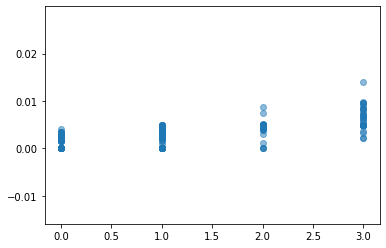

In [55]:
plt.scatter(df.posterior.values, np.sqrt(mses), alpha=0.5)

In [56]:
all_df = pd.DataFrame()
all_df['anterior'] = df.anterior
all_df['posterior'] = df.posterior
all_df['rmse'] = np.sqrt(mses)

In [57]:
all_df.to_csv('/Users/sean/Desktop/all_df.csv')

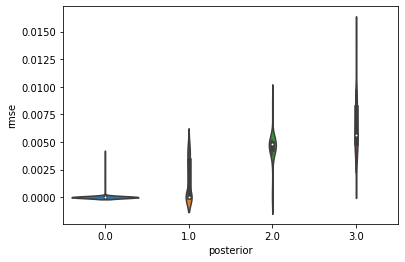

In [58]:
sns.violinplot(x='posterior', y='rmse', data=all_df)

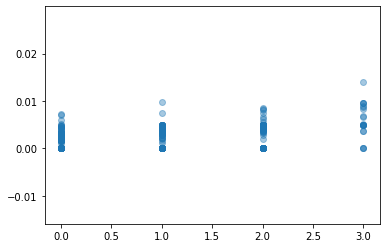

In [59]:
plt.scatter(df.anterior.values, np.sqrt(mses), alpha=0.4)

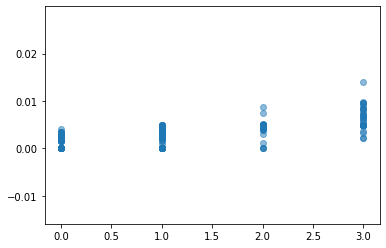

In [62]:
plt.scatter(all_df.posterior.values, all_df.rmse, alpha=0.5)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [69]:
from sklearn.linear_model import LogisticRegression

In [188]:
X = all_df.rmse.values.reshape(-1,1)
y_true = all_df.posterior > 1

extreme_idx = df[(df.posterior == 0) | (df.posterior == 3)].index
X_extreme = X[extreme_idx]
y_true_extreme = y_true.values[extreme_idx]

array([[97.36279401,  2.63720599],
       [14.52991453, 85.47008547]])

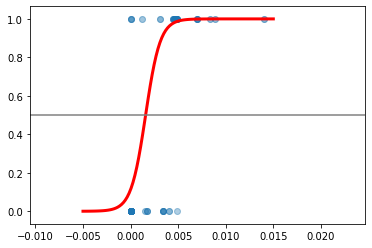

In [200]:
clf = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    C=1e5
)
clf.fit(X_extreme, y_true_extreme)

y_pred_extreme = clf.predict(X_extreme)

from scipy.special import expit

plt.scatter(X_extreme, y_true_extreme, alpha=0.1)
X_test = np.linspace(-.005,.015, 100)
loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)
plt.axhline(.5, color='.5')

cm = confusion_matrix(y_true_extreme, y_pred_extreme)
100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]